# Timing Inference

In [14]:
import time
import json
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import transformers
from transformers import AutoConfig, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
from adjustText import adjust_text
from matplotlib import cm
plt.style.use('seaborn-colorblind')
%matplotlib inline
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
def get_inference_speed(model, seq_len=256, bs=1, n_trials=1, device="cpu"):
    config = AutoConfig.from_pretrained(model, num_labels=4)
    if "gpt" in model:  # we don't use the tokenizer but this prevents errors:
        config.pad_token_id = config.eos_token_id
    model = AutoModelForSequenceClassification.from_config(config)
    model.eval()
    model.to(device)
    input_ids = torch.randint(0, 10000, (bs, seq_len))
    with torch.no_grad():
        start = time.time()
        for _ in range(n_trials):
            model(input_ids)
        end = time.time()
        return (end - start) / n_trials


def gather_all_speeds(
    models,
    batch_sizes=[1, 2, 4, 8, 16, 32, 64, 128],
    seq_lens=[32, 64, 128, 256, 512],
    n_trials=1,
    device="cpu",
    threads=24,
):  
    torch.set_num_interop_threads(threads) # Inter-op parallelism
    torch.set_num_threads(threads)
    results = []
    for bs in batch_sizes:
        for seq_len in seq_lens:
            for model in models:
                speed = get_inference_speed(model, seq_len, bs, n_trials, device)
                results.append({"model": model, "bs": bs, "seq_len": seq_len, "speed": speed})
    results = pd.DataFrame(results, columns=["model", "bs", "seq_len", "speed"])
    return results


models = [
    "albert-base-v2",
    "bert-base-uncased",
    "distilgpt2",
    "distilroberta-base",
    "EleutherAI/gpt-neo-125M",
    "facebook/muppet-roberta-base",
    "funnel-transformer/medium-base",
    "funnel-transformer/small-base",
    "google/bigbird-roberta-base",
    "google/electra-base-discriminator",
    "google/mobilebert-uncased",
    "gpt2",
    "microsoft/deberta-v3-base",
    "roberta-base",
    "squeezebert/squeezebert-uncased",
]

device = "cpu"
threads = 24
results = gather_all_speeds(
    models,
    batch_sizes=[1],
    seq_lens=[16, 32, 64, 128],
    n_trials=1,
    device=device,
    threads=threads,
)

## Comparing model accuracy and inference speed

We want high accuracy and high inference speed across a wide variety of datasets. First we will average accuracy across these datasets. Inference speed scales differently for different sequences lengths with each model, so we will average the inference time across sequence lengths between 32 and 512.

Here we look at the case of using CPU without batched inference, which is a likely use case with ?low demand? This is a practical case, because real time systems without very high useage are not good for batched inference. Unlike for training, cpu inference can be reasonably fast with smaller models, and has the benefit of cheaper hardware so in practice can be widely used.

! CHECK if real benefits of GPU over cpu happen with batched inference (must be high demand real time or offline). How do they compare with BS = 1?


***mobile bert has extremely poor performance with these training settings, so we omit it to make visualization easier ???why???***

,avg_acc,avg_speed
microsoft/deberta-v3-base,0.916820,0.108414
facebook/muppet-roberta-base,0.911131,0.062062
funnel-transformer/medium-base,0.909016,0.098813
roberta-base,0.904689,0.061692
funnel-transformer/small-base,0.901486,0.070776
google/electra-base-discriminator,0.899717,0.070970
google/bigbird-roberta-base,0.893186,0.085270
distilroberta-base,0.884226,0.030970
albert-base-v2,0.883528,0.059656
bert-base-uncased,0.882116,0.066915


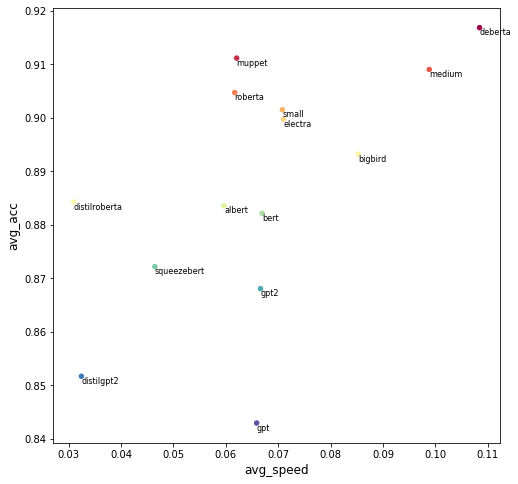

In [11]:
inference_speeds = pd.read_csv("results/inference_speed_cpu_24_while_train.csv")

inference_speeds = inference_speeds[inference_speeds.bs==1]
inference_speeds = inference_speeds.pivot(index="model", columns=["seq_len"], values="speed")
inference_speeds['avg_speed'] = inference_speeds.mean(axis=1)

accs = pd.read_csv("results/accuracies.csv", index_col=0)
accs = accs[accs.index!="google/mobilebert-uncased"]
accs.rename(columns={"avg": "avg_acc"}, inplace=True)
df = pd.merge(accs[['avg_acc']], inference_speeds[['avg_speed']], left_index=True, right_index=True)
display(df.sort_values(by="avg_acc", ascending=False))

fig, ax = plt.subplots(figsize=(8, 8))
cmap = cm.get_cmap('Spectral')
df.plot(kind="scatter", x="avg_speed", y="avg_acc", c=range(len(df)), colormap=cmap, ax=ax)

for k, v in df.iterrows():
    ax.annotate(k, v,
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=18, color='darkslategrey')
    # ax.text(point['x'], point['y'], str(point['val']))
texts = []
for idx, model in enumerate(df.index.to_list()):
    label = model.split("/")[-1].split("-")[0]
    t = ax.text(df["avg_speed"][idx], df["avg_acc"][idx], label, ha='left', va='top', size=8)
    texts.append(t)



Clear winners here are distil roberta, Muppet Roberta, and Deberta depending how much performance vs. accuracy matter.

Anything based on the older GPT or BERT models perform quite poorly and should be avoided.

,sst2,qqp,mnli,qnli,boolq,ag_news,imdb,snli,rotten_tomatoes,yelp_polarity,eraser_multi_rc,wiki_qa,scitail,emotion,tweet_eval_hate
microsoft/deberta-v3-base,0.954128,0.922632,0.897708,0.937763,0.828440,0.950000,0.96084,0.933042,0.908068,0.983895,0.833541,0.944749,0.965491,0.9360,0.796
facebook/muppet-roberta-base,0.963303,0.915681,0.876719,0.931173,0.829969,0.946974,0.95676,0.917192,0.917448,0.981500,0.813628,0.956824,0.956288,0.9335,0.770
funnel-transformer/medium-base,0.942661,0.918526,0.887519,0.926963,0.833639,0.940000,0.95832,0.927962,0.909944,0.982868,0.780025,0.945481,0.969325,0.9350,0.777
roberta-base,0.948394,0.915978,0.873663,0.926414,0.799083,0.948553,0.95448,0.917801,0.886492,0.981395,0.783759,0.946945,0.949387,0.9340,0.804
funnel-transformer/small-base,0.943807,0.915607,0.882323,0.921106,0.791437,0.945132,0.95576,0.921459,0.906191,0.981447,0.767579,0.944749,0.963190,0.9315,0.751
google/electra-base-discriminator,0.944954,0.916992,0.884870,0.928977,0.749847,0.944605,0.95368,0.922882,0.895872,0.981500,0.771002,0.942188,0.949387,0.9340,0.775
google/bigbird-roberta-base,0.938073,0.910463,0.872440,0.909207,0.782263,0.943026,0.94912,0.917903,0.896811,0.980526,0.707841,0.954995,0.937117,0.9340,0.764
distilroberta-base,0.923165,0.907643,0.841161,0.913967,0.737003,0.948684,0.94360,0.900528,0.864916,0.978684,0.701929,0.939627,0.930982,0.9385,0.793
albert-base-v2,0.910550,0.901583,0.838411,0.912319,0.739144,0.942895,0.93772,0.904999,0.862101,0.976868,0.753267,0.948042,0.955521,0.9405,0.729
bert-base-uncased,0.923165,0.905936,0.837901,0.911587,0.710398,0.940658,0.93776,0.907844,0.857411,0.977368,0.706907,0.956824,0.942485,0.9375,0.778


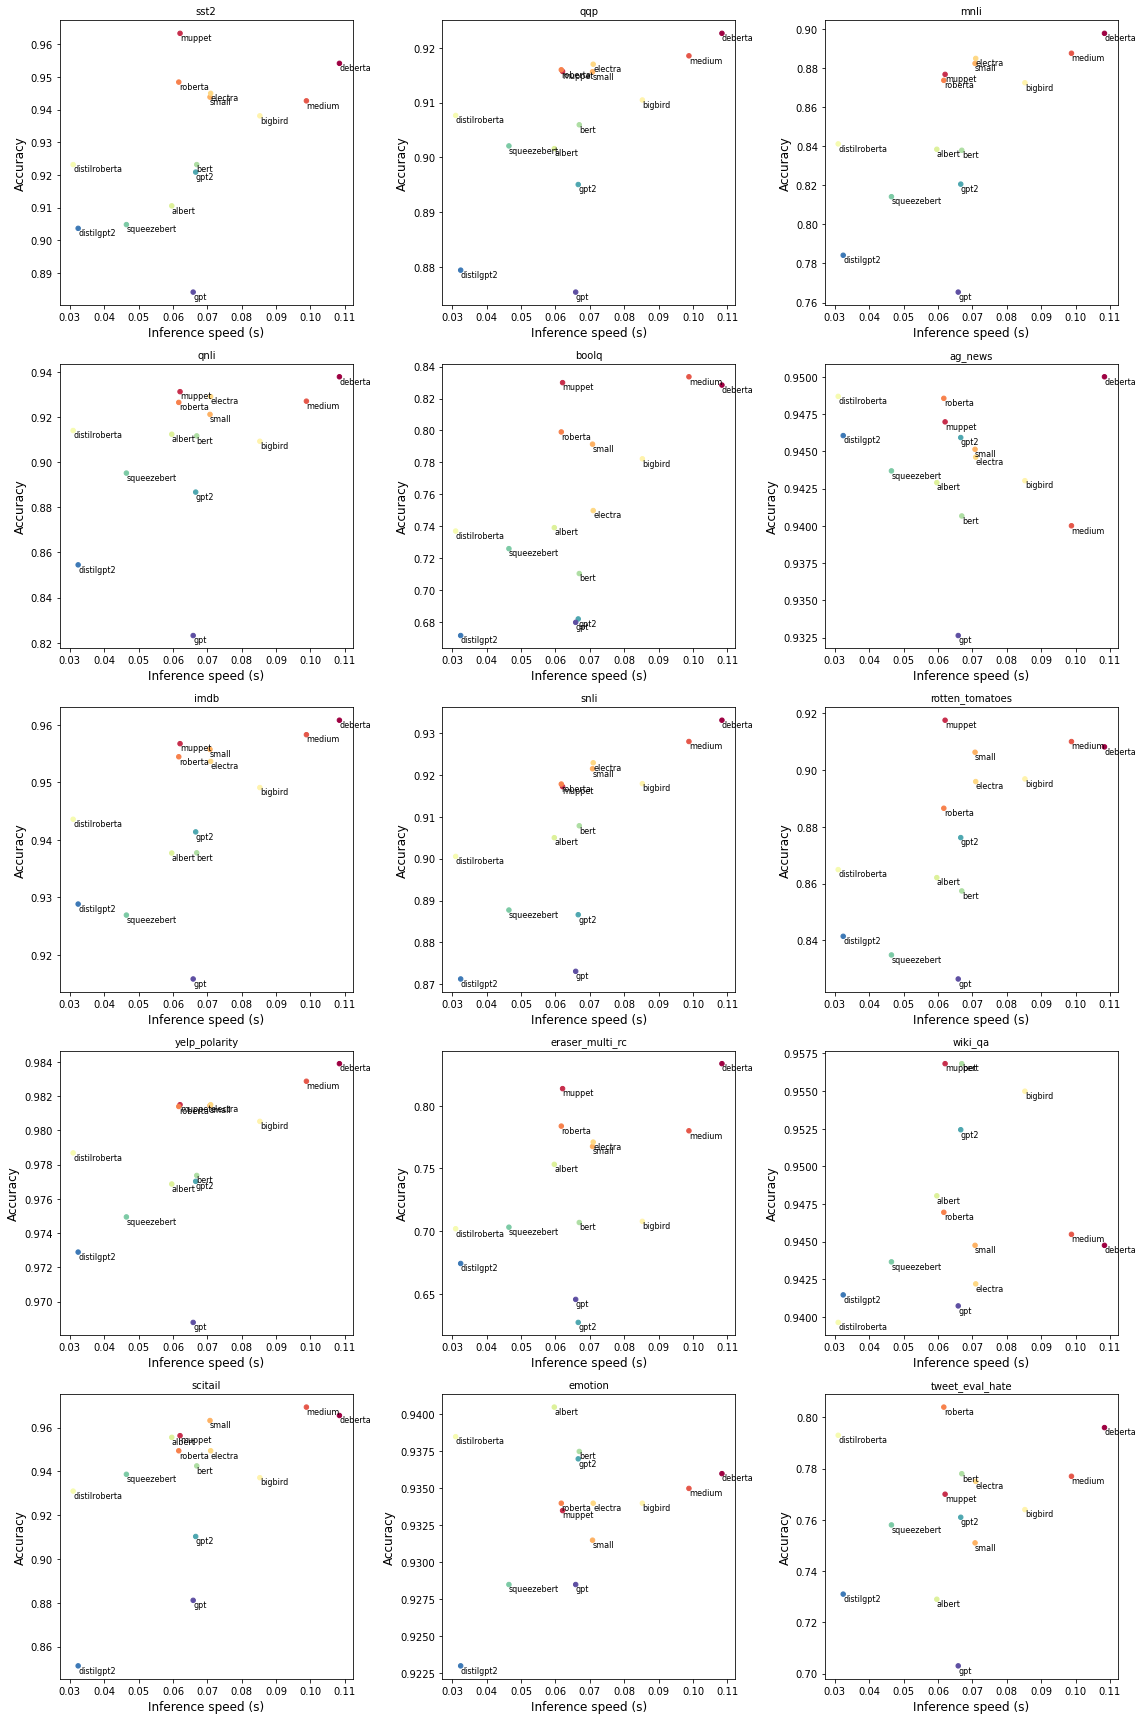

In [39]:
inference_speeds = pd.read_csv("results/inference_speed_cpu_24_while_train.csv")
inference_speeds = inference_speeds[inference_speeds.bs==1]
inference_speeds = inference_speeds.pivot(index="model", columns=["seq_len"], values="speed")
inference_speeds['avg_speed'] = inference_speeds.mean(axis=1)

accs = pd.read_csv("results/accuracies.csv", index_col=0)
accs = accs[accs.index!="google/mobilebert-uncased"]
accs.drop(columns="avg", inplace=True)
display(accs)

# Plotting the results for all datasets as subplots
fig, axes = plt.subplots(5, 3, figsize=(16, 24))
cmap = cm.get_cmap('Spectral')
for idx, (dataset, ax) in enumerate(zip(accs, axes.flatten())):
    df = pd.merge(accs[[dataset]], inference_speeds[['avg_speed']], left_index=True, right_index=True)
    df.plot(kind="scatter", x="avg_speed", y=dataset, c=range(len(df)), colormap=cmap, ax=ax)
    ax.set_title(dataset)
    ax.set_xlabel("Inference speed (s)")
    ax.set_ylabel("Accuracy")
    for k, v in df.iterrows():
        ax.annotate(k, v,
                    xytext=(10,-5), textcoords='offset points',
                    family='sans-serif', fontsize=18, color='darkslategrey')
    texts = []
    for idx, model in enumerate(df.index.to_list()):
        label = model.split("/")[-1].split("-")[0]
        t = ax.text(df["avg_speed"][idx], df[dataset][idx], label, ha='left', va='top', size=8)
        texts.append(t)
plt.tight_layout()
plt.savefig("results/accuracy_vs_speed.png")

## Performace by Sequence Length
Visualize performance with different sequence lengths.

A different slope indicates different scaling behavior with longer sequences.

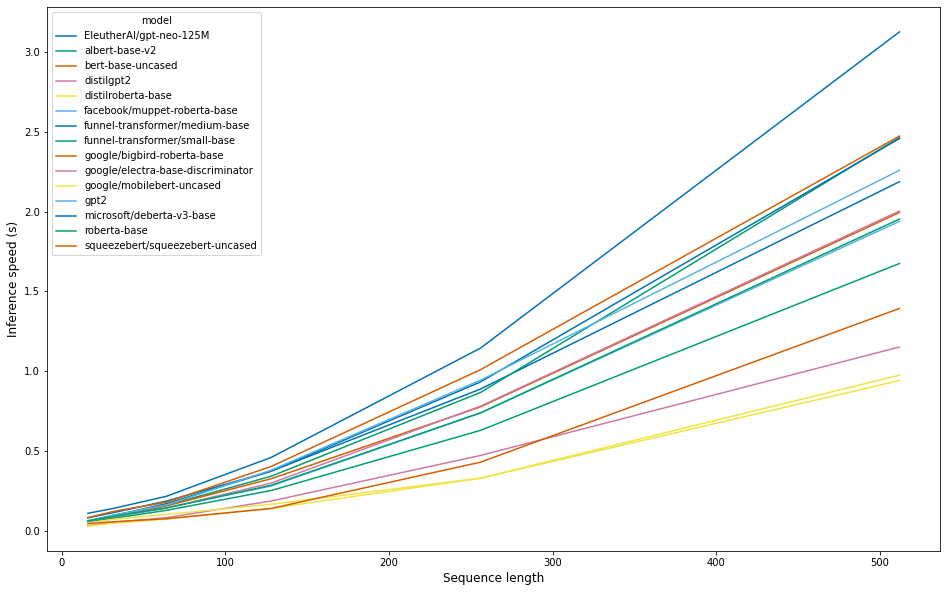

In [15]:
results = pd.read_csv('results/inference_speed_cpu_24_while_train.csv')
df = results.pivot_table(index="seq_len", columns="model", values="speed")
ax = df.plot(figsize=(16, 10), xlabel="Sequence length", ylabel="Inference speed (s)")
ax.figure.savefig('results/inference_speed_seq_len.png')

<AxesSubplot:xlabel='Sequence length', ylabel='Inference speed (s)'>

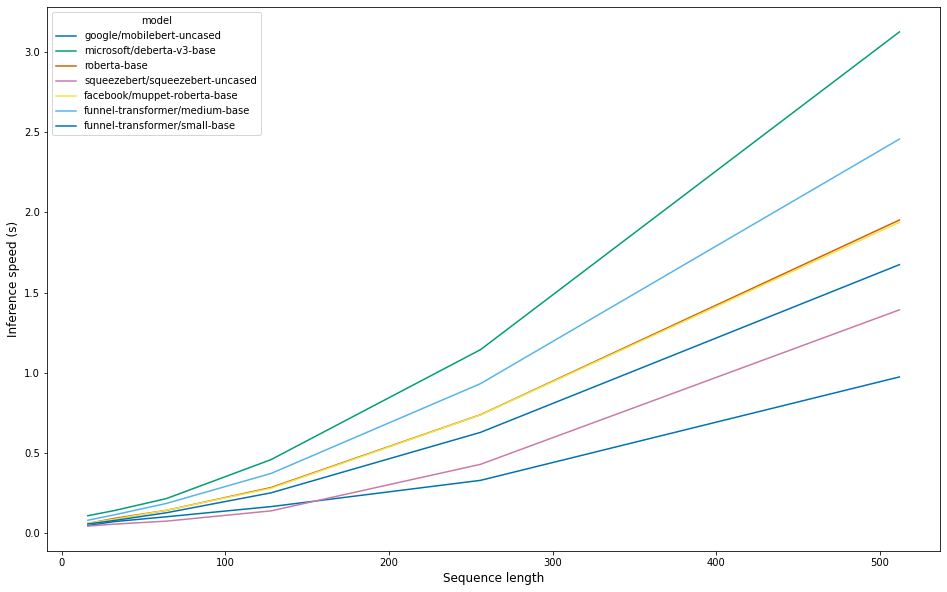

In [13]:
results = pd.read_csv('results/inference_speed_cpu_24_while_train.csv')
df = results.pivot_table(index="seq_len", columns="model", values="speed")
df = df[['google/mobilebert-uncased', 'microsoft/deberta-v3-base', 'roberta-base', 'squeezebert/squeezebert-uncased', 'facebook/muppet-roberta-base', 'funnel-transformer/medium-base', 'funnel-transformer/small-base']]
df.plot(figsize=(16, 10), xlabel="Sequence length", ylabel="Inference speed (s)")